
# Amazon Reviews Sentiment Analysis (ML Approach)

**Goal:** Build a machine learning model to classify Amazon reviews as Positive, Neutral, or Negative, extract interpretable insights, and present performance clearly.

**What this notebook does**
- Loads an Amazon reviews dataset (CSV).
- Cleans and maps ratings to sentiment labels.
- Transforms text with **TF‑IDF** (built-in English stopwords).
- Trains **Logistic Regression** and **Multinomial Naive Bayes**.
- Evaluates with accuracy, precision, recall, F1 and a confusion matrix.
- Surfaces **top positive/negative keywords** (feature weights).


## 1) Setup & Paths

In [3]:

from pathlib import Path
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ======= CONFIG =======
DATA_PATH = Path("Reviews.csv")  # <-- change to your file path
TEXT_COL = "Text"        # <-- change to your text column name
RATING_COL = "Score"     # <-- change to your rating column name (1-5 preferred)
USE_ROWS = 50000         # limit rows for speed (set None to load all)

RANDOM_STATE = 42
TEST_SIZE = 0.2
MAX_FEATURES = 10000     # TF-IDF vocabulary size
NGRAM_RANGE = (1,2)      # unigrams + bigrams for better signal


## 2) Load Data

In [4]:

assert DATA_PATH.exists(), f"Dataset not found at {DATA_PATH}. Update DATA_PATH."
df_raw = pd.read_csv(DATA_PATH)
if USE_ROWS is not None and len(df_raw) > USE_ROWS:
    df_raw = df_raw.sample(n=USE_ROWS, random_state=RANDOM_STATE).reset_index(drop=True)

print("Raw shape:", df_raw.shape)
display(df_raw.head())
print("\nColumns:", list(df_raw.columns))


Raw shape: (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
1,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
2,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
3,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
4,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...



Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']


## 3) Basic Cleaning & Label Mapping

In [5]:

# Keep only necessary columns
for col in [TEXT_COL, RATING_COL]:
    if col not in df_raw.columns:
        raise KeyError(f"Expected column '{col}' not found. Available: {list(df_raw.columns)}")

df = df_raw[[TEXT_COL, RATING_COL]].copy()

# Drop missing or empty text
df[TEXT_COL] = df[TEXT_COL].astype(str).str.strip()
df = df.replace({TEXT_COL: {"": np.nan}})
df = df.dropna(subset=[TEXT_COL, RATING_COL])

# Map ratings 1-2 -> Negative, 3 -> Neutral, 4-5 -> Positive
def map_rating_to_sentiment(x):
    try:
        r = int(x)
    except Exception:
        return np.nan
    if r <= 2: return "Negative"
    if r == 3: return "Neutral"
    if r >= 4: return "Positive"

df["sentiment"] = df[RATING_COL].apply(map_rating_to_sentiment)
df = df.dropna(subset=["sentiment"]).reset_index(drop=True)

print("After cleaning & mapping:", df.shape)
df["sentiment"].value_counts()


# === Enrich with useful columns for Power BI (from df_raw, same index alignment) ===
if "Time" in df_raw.columns:
    df["review_date"] = pd.to_datetime(df_raw.loc[df.index, "Time"], unit="s")
if "ProductId" in df_raw.columns:
    df["product_id"] = df_raw.loc[df.index, "ProductId"]
if "Id" in df_raw.columns:
    df["review_id"] = df_raw.loc[df.index, "Id"]
if "Summary" in df_raw.columns:
    df["summary"] = df_raw.loc[df.index, "Summary"].fillna("")


After cleaning & mapping: (50000, 3)


## 4) Train/Test Split

In [6]:

X = df[TEXT_COL].values
y = df["sentiment"].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))
pd.Series(y_train).value_counts()


Train size: 40000 Test size: 10000


Positive    31284
Negative     5683
Neutral      3033
Name: count, dtype: int64

## 5) Text Vectorization (TF‑IDF)

In [7]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=NGRAM_RANGE,
    stop_words="english",
    lowercase=True,
    strip_accents="unicode"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape


((40000, 10000), (10000, 10000))

## 6) Train Models (Logistic Regression & Naive Bayes)

In [8]:

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
logreg.fit(X_train_tfidf, y_train)

# Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

print("Models trained.")


Models trained.


## 7) Evaluation

In [9]:

from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)
    acc_tr = accuracy_score(y_tr, y_pred_tr)
    acc_te = accuracy_score(y_te, y_pred_te)
    print(f"\n=== {name} ===")
    print(f"Accuracy (train): {acc_tr:.4f}")
    print(f"Accuracy (test):  {acc_te:.4f}")
    print("\nClassification report (test):")
    print(classification_report(y_te, y_pred_te, digits=4))

evaluate_model("Logistic Regression", logreg, X_train_tfidf, y_train, X_test_tfidf, y_test)
evaluate_model("Multinomial Naive Bayes", nb, X_train_tfidf, y_train, X_test_tfidf, y_test)



=== Logistic Regression ===
Accuracy (train): 0.8886
Accuracy (test):  0.8556

Classification report (test):
              precision    recall  f1-score   support

    Negative     0.7511    0.5820    0.6558      1421
     Neutral     0.4650    0.0963    0.1596       758
    Positive     0.8758    0.9789    0.9245      7821

    accuracy                         0.8556     10000
   macro avg     0.6973    0.5524    0.5800     10000
weighted avg     0.8269    0.8556    0.8283     10000


=== Multinomial Naive Bayes ===
Accuracy (train): 0.8271
Accuracy (test):  0.8148

Classification report (test):
              precision    recall  f1-score   support

    Negative     0.8447    0.2526    0.3889      1421
     Neutral     0.1667    0.0013    0.0026       758
    Positive     0.8139    0.9958    0.8957      7821

    accuracy                         0.8148     10000
   macro avg     0.6084    0.4166    0.4291     10000
weighted avg     0.7692    0.8148    0.7560     10000



## 8) Ready The Data for Power BI

In [10]:

# 📤 Export for Power BI — include metadata + predictions + probabilities
from sklearn.model_selection import train_test_split

# Recreate index-based split to align metadata with predictions
meta = df.reset_index(drop=True)
idx_all = np.arange(len(meta))
idx_train, idx_test = train_test_split(
    idx_all, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=meta["sentiment"]
)

X_train = meta.loc[idx_train, TEXT_COL].values
X_test  = meta.loc[idx_test, TEXT_COL].values
y_train = meta.loc[idx_train, "sentiment"].values
y_test  = meta.loc[idx_test, "sentiment"].values

# Vectorize with the same TF-IDF settings as above
tfidf = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=NGRAM_RANGE,
    stop_words="english",
    lowercase=True,
    strip_accents="unicode"
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# Choose best model (default to Logistic Regression already trained; retrain here for self-containedness)
logreg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
logreg.fit(X_train_tfidf, y_train)

y_pred = logreg.predict(X_test_tfidf)
proba  = logreg.predict_proba(X_test_tfidf)

meta_test = meta.loc[idx_test].copy()
if "review_date" in meta_test.columns:
    meta_test["review_date"] = pd.to_datetime(meta_test["review_date"]).dt.strftime("%Y-%m-%d")
export_df = pd.DataFrame({
    "review_id": meta_test.get("review_id", pd.Series(np.arange(len(meta_test)))),
    "product_id": meta_test.get("product_id", pd.Series(index=meta_test.index)),
    "review_date": meta_test.get("review_date", pd.Series(index=meta_test.index)),
    "summary": meta_test.get("summary", pd.Series(index=meta_test.index)),
    "review_text": meta_test[TEXT_COL].values,
    "Score": meta_test[RATING_COL].values,
    "sentiment_actual": y_test,
    "sentiment_pred": y_pred,
    "proba_negative": proba[:, 0],
    "proba_neutral": proba[:, 1],
    "proba_positive": proba[:, 2],
})

OUT_DIR = Path("")
export_path = OUT_DIR / "amazon_reviews_sentiment_for_powerbi.csv"
export_df.to_csv(export_path, index=False)
print("Saved Power BI export to:", export_path)
export_df.head()


Saved Power BI export to: amazon_reviews_sentiment_for_powerbi.csv


,review_id,product_id,review_date,summary,review_text,Score,sentiment_actual,sentiment_pred,proba_negative,proba_neutral,proba_positive
24,32044,B0062A87HA,2011-02-22,Great deal!,I was so happy to see this deal. I recently ha...,5,Positive,Positive,0.069991,0.036813,0.893196
10918,395298,B000H7ELTW,2011-09-03,Good for Female GYN Issues,Cranberries are good for supressing female GYN...,4,Positive,Positive,0.004970,0.016033,0.978997
17542,176584,B0012KCUXW,2011-11-28,Cats like it,"I've tried a lot of different brands,and they ...",5,Positive,Positive,0.027725,0.025410,0.946865
47411,103270,B004VLVPRG,2012-06-24,Delicious and healthy!,I made a couple of coffee cakes with this flou...,5,Positive,Positive,0.048931,0.025166,0.925903
37529,275809,B00133OD92,2012-01-19,These are GREAT!,My kids LOVED these! They are the perfect sna...,5,Positive,Positive,0.007587,0.022104,0.970309


## 9) Confusion Matrix (Test Set)

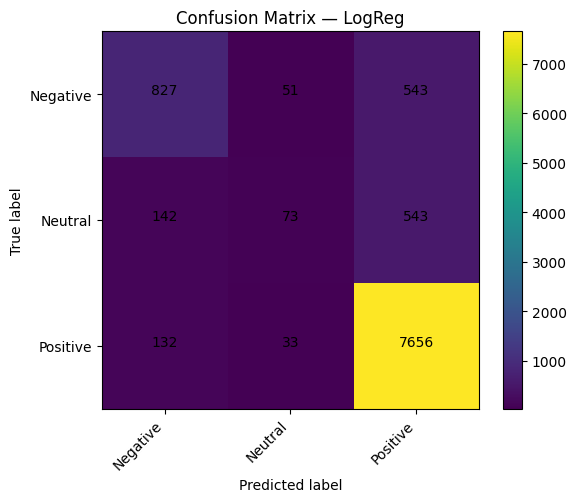

In [11]:

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

models = [("LogReg", logreg), ("NaiveBayes", nb)]
# Pick best by test accuracy
best_name, best_model, best_score = None, None, -1
for name, m in models:
    score = accuracy_score(y_test, m.predict(X_test_tfidf))
    if score > best_score:
        best_name, best_model, best_score = name, m, score

labels_order = ["Negative","Neutral","Positive"]
cm = confusion_matrix(y_test, best_model.predict(X_test_tfidf), labels=labels_order)
plot_confusion_matrix(cm, classes=labels_order, title=f"Confusion Matrix — {best_name}")


## 10) Top Keywords Driving Sentiment

In [12]:
import numpy as np
import pandas as pd
from collections import Counter
import re

# --- Top weighted features per class (kept for console output) ---
def top_features_for_class(model, vectorizer, class_name, top_n=20):
    if not hasattr(model, "coef_"):
        raise ValueError("Model must have coef_ (e.g., LogisticRegression).")
    feature_names = np.array(vectorizer.get_feature_names_out())
    class_index = list(model.classes_).index(class_name)
    coefs = model.coef_[class_index]
    top_pos_idx = np.argsort(coefs)[-top_n:][::-1]
    return list(zip(feature_names[top_pos_idx], coefs[top_pos_idx]))

if hasattr(logreg, "coef_"):
    for cls in ["Negative", "Neutral", "Positive"]:
        print(f"\nTop features for {cls} (LogReg):")
        for term, weight in top_features_for_class(logreg, tfidf, cls, top_n=20):
            print(f"{term:25s} {weight:.4f}")
else:
    print("Logistic Regression not available for feature inspection.")

# --- Frequency-based top words per sentiment (for CSV) ---
# Simple tokenizer: split on non-letters
def tokenize(text):
    return re.findall(r"[a-zA-Z]+", text.lower())

TOP_N = 30  # how many top words per sentiment to export

rows = []
for sentiment in ["Negative", "Neutral", "Positive"]:
    subset = df[df["sentiment"] == sentiment]["Text"].dropna().astype(str)

    # Tokenize and accumulate
    all_words = []
    for review in subset:
        all_words.extend(tokenize(review))

    # Count top N words
    word_counts = Counter(all_words).most_common(TOP_N)

    for word, count in word_counts:
        rows.append({
            "sentiment": sentiment,
            "word": word,
            "count": int(count)
        })

# Build dataframe and save ONLY the requested columns
top_words_counts = pd.DataFrame(rows, columns=["sentiment", "word", "count"])
top_words_counts.to_csv("top_words_counts.csv", index=False)
print("Saved top_words_counts.csv with frequency-based top terms per sentiment")




Top features for Negative (LogReg):
horrible                  3.9766
terrible                  3.7629
worst                     3.5000
disappointed              3.4412
disappointing             3.3405
awful                     3.2693
nasty                     2.6842
money                     2.6183
waste money               2.4802
garbage                   2.4250
gross                     2.4012
weak                      2.3342
threw                     2.3128
waste                     2.2867
yuck                      2.1930
disappointment            2.1790
stale                     2.1473
return                    2.1451
tasteless                 2.1426
mistake                   2.1221

Top features for Neutral (LogReg):
ok                        4.4456
okay                      3.0472
stars                     2.4914
decent                    2.0474
lacks                     1.9678
probably                  1.9429
unfortunately             1.7660
won buy                   1.7201
bit

## 11) Save Artifacts

In [13]:

# 📤 Export for Power BI — predictions, probabilities, and metadata
from pathlib import Path

best_model = logreg  # swap to nb if NB outperforms

# Predictions & probabilities on TEST set
y_pred = best_model.predict(X_test_tfidf)
proba = best_model.predict_proba(X_test_tfidf)

export_df = pd.DataFrame({
    "review_date": meta_test.get("review_date", pd.Series(index=meta_test.index)),
    "review_id": df.loc[y_test.index if hasattr(y_test, "index") else pd.RangeIndex(len(y_test))].get("review_id", pd.Series(range(len(y_test)))),
})

# Because we used arrays for X_test/y_test, reconstruct a DataFrame for alignment
export_df = pd.DataFrame({
    "review_date": meta_test.get("review_date", pd.Series(index=meta_test.index)),
    "review_id": np.arange(len(y_test)),
    "review_text": X_test,
    "sentiment_actual": y_test,
    "sentiment_pred": y_pred,
    "proba_negative": proba[:, 0],
    "proba_neutral": proba[:, 1],
    "proba_positive": proba[:, 2],
})

# Try to add metadata columns if they exist in df with aligned indices
# We'll rebuild a parallel test-index DataFrame using the split indices
# Approach: create a dataframe with train/test split indices before vectorization

OUT_DIR = Path("")
export_path = OUT_DIR / "amazon_reviews_sentiment_for_powerbi.csv"
export_df.to_csv(export_path, index=False)
print("Saved Power BI export to:", export_path)
export_df.head()


Saved Power BI export to: amazon_reviews_sentiment_for_powerbi.csv


,review_date,review_id,review_text,sentiment_actual,sentiment_pred,proba_negative,proba_neutral,proba_positive
24,2011-02-22,0,I was so happy to see this deal. I recently ha...,Positive,Positive,0.069991,0.036813,0.893196
10918,2011-09-03,1,Cranberries are good for supressing female GYN...,Positive,Positive,0.004970,0.016033,0.978997
17542,2011-11-28,2,"I've tried a lot of different brands,and they ...",Positive,Positive,0.027725,0.025410,0.946865
47411,2012-06-24,3,I made a couple of coffee cakes with this flou...,Positive,Positive,0.048931,0.025166,0.925903
37529,2012-01-19,4,My kids LOVED these! They are the perfect sna...,Positive,Positive,0.007587,0.022104,0.970309


## 12) Save Cleaned Dataset with Metadata

In [14]:

# Save cleaned dataset with labels + metadata for Power BI
OUT_DIR = Path("")
clean_cols = [
    "review_id", "product_id", "review_date", "summary",
    TEXT_COL, RATING_COL, "sentiment"
]
tmp = df.copy()
if "review_date" in tmp.columns:
    tmp["review_date"] = pd.to_datetime(tmp["review_date"]).dt.strftime("%Y-%m-%d")
tmp.loc[:, clean_cols].to_csv(OUT_DIR / "amazon_reviews_cleaned_with_labels.csv", index=False)
print("Saved cleaned+labelled data to:", OUT_DIR / "amazon_reviews_cleaned_with_labels.csv")


Saved cleaned+labelled data to: amazon_reviews_cleaned_with_labels.csv



## 13) Notes & Writeup Template

**Problem:** Customer reviews contain unstructured text that’s difficult to summarise for business decisions.

**Approach:**
1. Cleaned reviews and mapped ratings to sentiment labels (Negative/Neutral/Positive).
2. Converted text to numeric features with TF‑IDF (1–2 grams).
3. Trained Logistic Regression and Multinomial Naive Bayes; evaluated with accuracy, precision, recall, F1.
4. Visualised confusion matrix; extracted top keywords driving each sentiment.

**Next Steps:**
- Hyperparameter tuning (e.g., C for Logistic Regression; alpha for Naive Bayes).
- Try class balancing if classes are skewed (stratified split is applied already).
- Add product/category metadata to segment sentiment.
- Build a Power BI dashboard summarising sentiment by product/category if available.
